<a href="https://colab.research.google.com/github/matanb1238/EmotionClassifier/blob/main/notebooksCovid_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("combined_cleaned_dataset.csv", encoding='latin1')
df.dropna(subset=['OriginalTweet', 'Sentiment', 'TweetDay', 'country'], inplace=True)

# Ensure labels are int (0=neg, 1=neutral, 2=pos)
df['label'] = df['Sentiment'].astype(int)

# Convert date to string for OneHot
df['TweetDay'] = df['TweetDay'].astype(str)

df.head()

,OriginalTweet,Sentiment,TweetDay,country,label
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2.0,2.0,United Kingdom,2
1,advice Talk to your neighbours family to excha...,0.0,2.0,United Kingdom,0
2,Coronavirus Australia: Woolworths to give elde...,0.0,2.0,Gabon,0
3,My food stock is not the only one which is emp...,0.0,2.0,Germany,0
4,"Me, ready to go at supermarket during the #COV...",1.0,2.0,Germany,1


In [2]:

import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#\w+", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"\d+", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_tweet'] = df['OriginalTweet'].apply(clean_text)

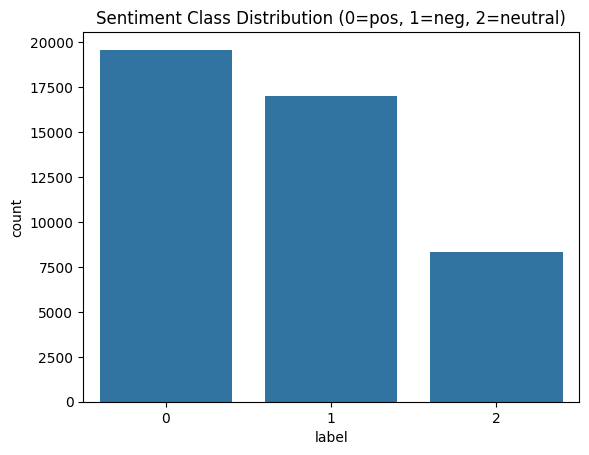

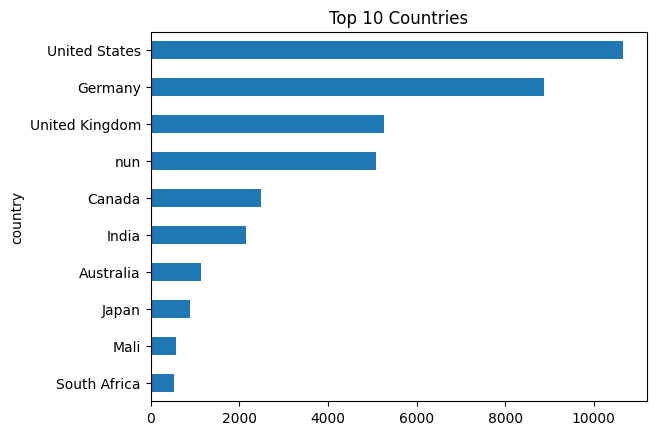

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment distribution
sns.countplot(x='label', data=df)
plt.title("Sentiment Class Distribution (0=pos, 1=neg, 2=neutral)")
plt.show()

# Most common countries
df['country'].value_counts().head(10).plot(kind='barh', title="Top 10 Countries")
plt.gca().invert_yaxis()
plt.show()

In [4]:

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

def preprocess_tokens(text):
    tokens = word_tokenize(text)
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

df['processed_tweet'] = df['clean_tweet'].apply(preprocess_tokens)

In [24]:
import gensim.downloader as api
model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [36]:
# -------------------------------
# Step 5: Feature Engineering - Choose Vectorization Method
# Options: "tfidf", "bow", "word2vec"
# -------------------------------

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np


VECTOR_TYPE = "word2vec"  # change to "bow" or "word2vec" later

# Word2Vec (optional)
if VECTOR_TYPE == "word2vec":
    # from gensim.models import Word2Vec

    # df['tokens'] = df['processed_tweet'].apply(word_tokenize)
    # w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=2, workers=4)

    # def tweet_to_vec(tokens):
    #     vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    #     return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

    # df['w2v_vector'] = df['tokens'].apply(tweet_to_vec)

    # X_vectors = np.vstack(df['w2v_vector'].values)

    # # One-hot encode country and TweetDay
    # encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    # X_cats = encoder.fit_transform(df[['country', 'TweetDay']])

    # X_final = np.hstack([X_vectors, X_cats])
    from gensim.models import KeyedVectors
    w2v_model = api.load("word2vec-google-news-300")

    def tweet_to_vec(text, model, dim=300):
        tokens = word_tokenize(text.lower())
        vectors = [model[word] for word in tokens if word in model]
        return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

    df['w2v_vector'] = df['processed_tweet'].apply(lambda x: tweet_to_vec(x, w2v_model))
    X_vectors = np.vstack(df['w2v_vector'].values)

    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_cats = encoder.fit_transform(df[['country', 'TweetDay']])
    X = np.hstack([X_vectors, X_cats])

else:
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english') if VECTOR_TYPE == "tfidf" \
                 else CountVectorizer(max_features=5000, stop_words='english')

    preprocessor = ColumnTransformer([
        ('text', vectorizer, 'processed_tweet'),
        ('country', OneHotEncoder(handle_unknown='ignore'), ['country']),
        ('day', OneHotEncoder(handle_unknown='ignore'), ['TweetDay'])
    ])

    X = df[['processed_tweet', 'country', 'TweetDay']]


In [37]:
from sklearn.model_selection import train_test_split

if VECTOR_TYPE == "word2vec":
    # (Train+Validation) & Test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, df['label'], test_size=0.2, random_state=42, stratify=df['label']
    )

    # Train & Validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
    )

else:
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, df['label'], test_size=0.2, random_state=42, stratify=df['label']
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
    )


In [38]:
# -------------------------------
# Step 7: Train model (Logistic, SVM, Random Forest, etc.)
# -------------------------------

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

MODEL_TYPE = "random_forest"

# Choose classifier
if MODEL_TYPE == "logistic":
    classifier = LogisticRegression(max_iter=1000, multi_class='multinomial')
elif MODEL_TYPE == "svm":
    classifier = SVC(kernel='linear', decision_function_shape='ovr')
elif MODEL_TYPE == "random_forest":
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
elif MODEL_TYPE == "adaboost":
    base = DecisionTreeClassifier(max_depth=2)
    classifier = AdaBoostClassifier(estimator=base, n_estimators=100, learning_rate=1.0, random_state=42)
else:
    raise ValueError("Invalid MODEL_TYPE")

# If using TF-IDF or BoW, use pipeline to apply preprocessing
if VECTOR_TYPE in ["tfidf", "bow"]:
    model = Pipeline([
        ('preprocess', preprocessor),  # your ColumnTransformer from Step 5
        ('classifier', classifier)
    ])
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

# If using Word2Vec (already numeric)
elif VECTOR_TYPE == "word2vec":
    classifier.fit(X_train, y_train)
    y_val_pred = classifier.predict(X_val)
    y_test_pred = classifier.predict(X_test)

print("📊 Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print("📊 Final Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))



📊 Validation Accuracy: 0.6543862088141248
              precision    recall  f1-score   support

           0       0.63      0.80      0.71      3135
           1       0.67      0.67      0.67      2725
           2       0.74      0.29      0.42      1333

    accuracy                           0.65      7193
   macro avg       0.68      0.59      0.60      7193
weighted avg       0.67      0.65      0.64      7193

📊 Final Test Accuracy: 0.6464242019797576
              precision    recall  f1-score   support

           0       0.63      0.79      0.70      3919
           1       0.66      0.65      0.66      3406
           2       0.74      0.29      0.42      1666

    accuracy                           0.65      8991
   macro avg       0.68      0.58      0.59      8991
weighted avg       0.66      0.65      0.63      8991

